# 4. Using pretrained models

One of the most common ways people use DNNs is through pretrained models. As we've seen up till now, even the smaller NNs we've trained on tiny datasets take a while. Imagine trying to train a billion-parameter model in a huge dataset. This would require **considerable resources** (prohibitive for most of us), as well as **a lot of time**.

Thankfully, other people have done this work for us and are kind enough to share their trained models! This means that we have access to incredibly strong models and can use them in various ways. We will maily focus on 4:

1. **Zero-shot**: using a pretrained model out-of-the-box.
2. **Feature extraction**: similar to the previous, but we will use the model only for feature extraction.
3. **Transfer learning**: adapt a pretrained model trained on one task to another task we want to solve (we will examine only **fine-tuning**)
4. **Partial warm-start**: a more extreme version of the previous, where we will selectively take parts of the pretrained model that interest us (e.g. trained embedding tables) for our own custom model.

*Note: the names I'm giving to these categories aren't 100% theoretically sound, though they'll help us better distinguish one category from the other.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

assert tf.__version__[0] == '2', 'this tutorial is for tensorflow versions of 2 or higher'

2023-04-15 01:06:42.720874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 01:06:43.216535: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-15 01:06:43.216589: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-15 01:06:44.535106: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Finding pretrained models

There are several repositories where we can find pretrained models. Some in fact offer their own API so that we can more conveniently download the pretrained model we want. The most popular are:

- Built-in TensorFlow/Keras models
- [Huggingface](https://huggingface.co/)
- [TensorFlow Hub](https://www.tensorflow.org/hub)

## 1. Zero-shot

We will call this zero-shot$^1$, because in this case we won't train the model at all. Instead we will use the pretrained model as is.

$^1$ *The term zero-shot isn't 100% accurate. It refers to cases where we use the model on a different task than what it has been trained on, without any retraining.*

### Example: Semantic segmentation with SegFormer

The example we'll look at is from Huggingface. It is the largest repository that contains pretrained models and offers ones for all frameworks (TensorFlow, PyTorch, Jax, etc).

We won't go into details of what semantic segmentation is. If you are not familiar with the task and want to learn more you can read [this article](https://www.v7labs.com/blog/semantic-segmentation-guide), however it is not necessary to follow along.

The idea here is that we want to download a pretrained model for semantic semgentation and use it completely out of the box. Usually two things are required for doing this
1. **The pretrained model**: this consists of the exact **network architecture** used, as well as the trained **weights** of the model.
2. **A preprocessing function**: this will convert an input to the **exact format expected by the model**. In image-related tasks, this usually involves reshaping the image, normalizing it and in some cases changing its channels (e.g. from RBG to grayscale).

For this specifix example we will use NVIDIA's Segformer [`segformer-b0-finetuned-ade-512-512`](https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512).

In [2]:
from transformers import AutoImageProcessor, TFSegformerForSemanticSegmentation


model_tag = 'nvidia/segformer-b0-finetuned-ade-512-512'

image_processor = AutoImageProcessor.from_pretrained(model_tag)

model = TFSegformerForSemanticSegmentation.from_pretrained(model_tag)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/thanos/.envs/tf-env/lib64/python3.9/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
2023-04-15 01:06:47.540359: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-15 01:06:47.540857: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-15 01:06:47.540999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (home): /proc/driver/nvi

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


Let's examine these two components. First of all let's see what the preprocessor does.

In [3]:
image_processor

SegformerImageProcessor {
  "do_normalize": true,
  "do_reduce_labels": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

The model is actually is hidden inside a Huggingface wrapper that facilitates interoperability between different frmeworks. We can take a look though at its components.

In [4]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMainL  multiple                 3319392   
 ayer)                                                           
                                                                 
 decode_head (TFSegformerDec  multiple                 433814    
 odeHead)                                                        
                                                                 
Total params: 3,753,206
Trainable params: 3,752,694
Non-trainable params: 512
_________________________________________________________________


Now to what we actually want to do. We'll download a random image from the web and ask our model to segment it.

In [5]:
from transformers import AutoImageProcessor, TFSegformerForSemanticSegmentation
from PIL import Image
import requests

url = 'https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fupload.wikimedia.org%2Fwikipedia%2Fcommons%2F4%2F43%2FChicago_River_buildings_(DDima).jpg&f=1&nofb=1&ipt=a5762cd76c940c66f458125a868d326b1f5f9532bb2c697e55e8e3dc4bf78608&ipo=images'
image = Image.open(requests.get(url, stream=True).raw)

image

To segment it we need to first preprocess it and then pass it to the model.

In [6]:
inputs = image_processor(images=image, return_tensors="tf")
outputs = model(**inputs, training=False)

logits = outputs.logits
logits.shape

TensorShape([1, 150, 128, 128])

Here the logits shape is `(batch, class, height, width)`. To actually see the predicted class we must use the argmax to select the highest value. If we want to see the actual probabilities we need to pass the logits through a softmax function. 

In [7]:
classes = np.argmax(outputs.logits[0], axis=0)  # argmax on the 'classes' dimension

A nice way to see the result of our segmentation is to overlay the segmentation mask on top of the original image. We'll define a helper function to do this. We also might want to ignore classes with very few pixels.

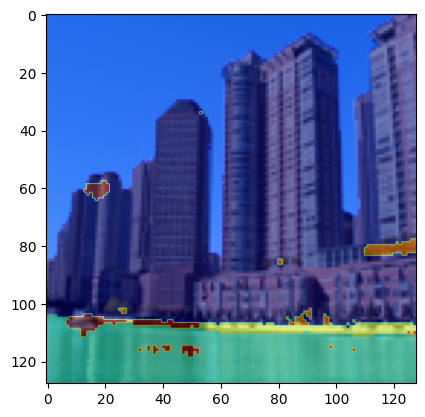

In [8]:
def overlay_top_N_classes(orig_image, seg_image, N=5, alpha=0.5):
    '''
    Overlay segmentation map on top of original image. The two images need
    to be in np.array format and need to have the same shape for this to 
    work properly.
    '''
    
    # Keep only the N classes with the most pixels
    series = pd.Series(seg_image.flatten())
    sorted_index = series.value_counts().index
    new_values = list(range(N)) + [N] * (len(sorted_index) - N)
    mapping = {k: v for k, v in zip(sorted_index, new_values)}
    overlay_image = series.map(mapping).values.reshape(seg_image.shape)

    # Plot the two omages
    plt.imshow(orig_image, cmap='gray')
    plt.imshow(overlay_image, cmap='jet', alpha=alpha)
    

overlay_top_N_classes(np.array(image.resize(classes.shape)), classes, N=5)

To get a better view of the segmentation mask we can set a higher value of `alpha`.

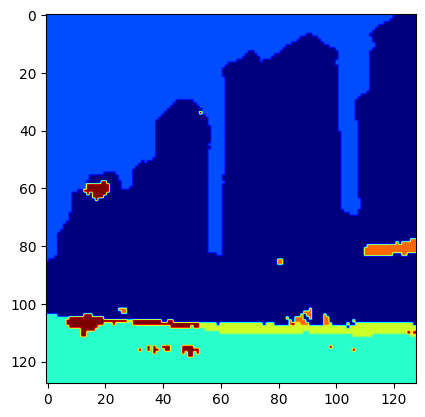

In [9]:
overlay_top_N_classes(np.array(image.resize(classes.shape)), classes, N=5, alpha=1.)

In [10]:
del model  # cleanup the memory

## 2. Feature extraction

In many cases we aren't interested in the prediction, but the model's **internal representation** of our input (in some cases this referred to as the **embedding**). Since the models are able to extract semantic information from the images this might help with several tasks, one of which is **semantic search**.

### Example: Semantic search from documents

For this example we'll download a dataset called the [20 newsgroups](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset), completely disregarding the labels. We'll then try to find documents based on semantic search (i.e. the query will return documents based on **semantic similarity** and not keyword search). Where will we get the semantics from? We'll use a well known Language Model called [`all-MiniLM-L6-v12`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2).

First, let's see the data

In [11]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups(subset='test')['data']

np.random.seed(13)
np.random.shuffle(data)
data = data[:100]

print(data[12])
print('-'*80)
print(data[85])

From: mmm@cup.portal.com (Mark Robert Thorson)
Subject: Re: INFO: Colonics and Purification?
Organization: The Portal System (TM)
Distribution: world
Lines: 8

Colonics were a health fad of the 19th century, which persists to this day.
Except for certain medical conditions, there is no reason to do this.
Certainly no normal person should do this.

Frequent use of enemas can lead to a condition in which a person is unable
to have normal bowel passage, essentially a person becomes addicted to
enemas.  As I understand it, this is a very unpleasant condition, and it
would be best to avoid it.

--------------------------------------------------------------------------------
From: strom@watson.ibm.com (Rob Strom)
Subject: Re: Waco survivors 1715 19 April
Disclaimer: This posting represents the poster's views, not necessarily those of IBM.
Nntp-Posting-Host: stockholm.watson.ibm.com
Organization: IBM Research
Lines: 84

In article <C5sEGz.Mwr@dscomsa.desy.de>, hallam@dscomsa.desy.de (Phill Ha

The documents are essentially emails, which are split into 20 different categories. For purposes of saving time we randomly subsampled them and kept only 100 documents.

Now let's look at the model.

In [12]:
from transformers import AutoTokenizer, TFAutoModel

model_tag = 'sentence-transformers/all-MiniLM-L6-v2'

# Load the models
tokenizer = AutoTokenizer.from_pretrained(model_tag)
model = TFAutoModel.from_pretrained(model_tag)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
tokenizer

BertTokenizerFast(name_or_path='sentence-transformers/all-MiniLM-L6-v2', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [14]:
model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  22713216  
                                                                 
Total params: 22,713,216
Trainable params: 22,713,216
Non-trainable params: 0
_________________________________________________________________


The tokenizer is meant to bring the raw text in the form expected by our model. This usually involves:
- **tokenization**: splitting the document into tokens (usually split in the subword level, i.e. more than one token per word), as well as adding special tokens (`[SEP]` for separating input segments, `[CLS]` at the beginning of the sequence, `[UNK]` for out-of-vocabulary words, etc.). Tokens are represented as integers.
- **truncation**: cutting the beginning tokens of the sequence if it exceeds the desired sequence length.
- **padding**: filling the end of the sequece with zeros if it is below the desired sequence length.

In [15]:
# Tokenize sentences
encoded_input = tokenizer(data, padding=True, truncation=True, return_tensors='tf')

As stated previously, we aren't interested in the model's actual output, but its internal representation. For this purpose we'll take the model's last hidden state. From this we can have the embedding for every word in the document. One thing we could do would be to average all of these (or even better use the attention mask to average them after ignoring the padded inputs). 

An arguably better approach is to simply use the model's representation for the `[CLS]` token, which is the fist token in the input and corresponds to the entire sequence.

In [16]:
outputs = model(**encoded_input)
outputs.last_hidden_state.shape

2023-04-15 01:07:05.339064: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1258291200 exceeds 10% of free system memory.
2023-04-15 01:07:05.652237: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1258291200 exceeds 10% of free system memory.
2023-04-15 01:07:05.912184: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1258291200 exceeds 10% of free system memory.
2023-04-15 01:07:06.183780: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1258291200 exceeds 10% of free system memory.
2023-04-15 01:07:06.382157: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1258291200 exceeds 10% of free system memory.


TensorShape([100, 512, 384])

The outputs have a shape of `(batch_size, sequence_length, embedding_dim)`. In our case the batch size is the number of documents we have. Let's extract the embedding for the `[CLS]` token for each document. 

In [17]:
embeddings = outputs.last_hidden_state[:, 0, :]
embeddings.shape

TensorShape([100, 384])

Now we have a $384$ dimensional embedding representing each document. 

Let's write a query. 

In [18]:
query = 'Luxury sports car'

# Encode the query
encoded_query = tokenizer([query], padding=True, truncation=True, return_tensors='tf')

# Use the model to embed the query
query_embedding = model(**encoded_query).last_hidden_state[:, 0, :]

query_embedding.shape

TensorShape([1, 384])

Now let's find the closest documents to this query.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity


def closestN(document_embeddings, query_embedding, N=5):
    '''
    Given a query embedding and an array of document embeddings, returns 
    the indices of top N most similar documents to the query.
    '''
    
    sim = cosine_similarity(embeddings, query_embedding)
    return np.argsort(sim[:, 0])[::-1][:N]

In [20]:
closest_3_idxs = closestN(embeddings, query_embedding, N=3)

for idx in closest_3_idxs:
    print(data[idx])
    print('-' * 80)

From: kenw@netaxs.com (Kenneth Warren)
Subject: Re: wife wants convertible
Organization: Net Access BBS & Network
Lines: 18
NNTP-Posting-Host: access.netaxs.com
X-Newsreader: TIN [version 1.1 PL9]

And here's my two cents:

The best convertible for the money, IMO, is the Miata. Yes, it's small, but
you're buying it as a second car, I hope, so you don't need the cargo room
of a big car. It's got enough power for fun, it's RWD like a sports car
ought to be (I'm gonna regret that :-{) and the top, while manual, operates
like a dream. 30 seconds and one hand to lower, and not much longer to raise.

The targa-type cars are nice, but they're not real convertibles.

--

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
  Ken Warren             |The secrets of a good life are early nights, good
                         |food, excercise, and clean living...
  E-Mail: kenw@netaxs.com|But the secrets of a happy life are late nights,
                         |wild parti

In [21]:
del model, embeddings, query_embedding, encoded_input, tokenizer, outputs   # cleanup the memory

## 3. Transfer Learning

Transfer Learning is an approach where we download a pretrained model (like in the previous two examples), but this time we will try to adapt it in some way for a different task than what it was trained for. There are many approaches to transfer learning, here we will focus on the most popular: **fine-tuning**. 

The process usually looks like this:
1. First we download a pretrained model, trained for a task similar to the one we want to solve.
2. In many cases it is necessary to slightly modify its architecture. Most commonly we might drop the last layer or layers and replace them with our own custom one. 
3. Then we will retrain the model on our own data. Because the model is initialized from the pretrained weights it isn't completely learing everything from scratch; instead it is continuing its training and adapting it to the task we are interested in. For this reason this is also referred to as **warm start**. Due to the previous reasons, in some cases we might want to either freeze the first layers of the network (to speedup the process and make sure it doesn't forget its prior knowledge), train with a smaller learning rate (because we don't want it to move too far away from its initial training) or train for fewer epochs (for the same reasons).

### Example: Fine-tuning a ResNet for cifar 

A [ResNet](https://arxiv.org/abs/1512.03385) is a family of CNNs used most commonly for image classification. We will use one of its variants called [ResNet50](https://keras.io/api/applications/resnet/#resnet50-function), originally trained on [ImageNet](https://www.image-net.org/challenges/LSVRC/) a large scale image dataset comprising of $1$ million images and $1000$ classes.

Luckily this model is built-in in keras.

In [22]:
resnet = tf.keras.applications.resnet.ResNet50(weights='imagenet', include_top=True)                

A few of things to note:
- both of these parameters are the default values, I manually set them on purpose to better illustrate what we are doing.
- if we just want access to the architecture and not the pretrained weights, we should set `weights=None`. 
- it would be better to set `include_top=False`, but it will give us a better understanding of keras models and the functional API to set it as True

Now let's take a look at the data we want to fine-tune our model on. We want to use the [CIFAR10](https://keras.io/api/datasets/cifar10/) dataset, which is a well known image classification dataset, also available from keras.

In [23]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [24]:
print(f'{x_train.shape=}')
print(f'{x_test.shape=}')
print(f'{y_train.shape=}')
print(f'{y_test.shape=}')
print(f'unique classes: {len(np.unique(y_train))}')

x_train.shape=(50000, 32, 32, 3)
x_test.shape=(10000, 32, 32, 3)
y_train.shape=(50000, 1)
y_test.shape=(10000, 1)
unique classes: 10


In first glance it would seem that this dataset is a incompatible with our model:
- our model outputs $1000$ classes, here we have only $10$
- our model expects $224\times 224$ images, here we have $32 \times 32$

To solve the first we need to modify our model's architecture. This is the step that would be easier to do if we had set `include_top=False`.

In [25]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

As we can see, this is a pretty complicated architecture. The model concludes with a GAP layer that aggregates its input to a $2048$ dimensional vector and a dense layer that outputs the final predictions. 

We need to swap this dense, with one of our own that has only $10$ outputs.

In [26]:
# Access the output of GAP layer
penultimate_output = resnet.layers[-2].output  

# Add a new output on top of the previous
new_output = tf.keras.layers.Dense(10, activation='softmax')(penultimate_output)

# Define and compile a new model that uses our output instead of the default one
resnet_cifar = tf.keras.models.Model(resnet.input, new_output)
resnet_cifar.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print its summary
resnet_cifar.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

Notice that we have swapped the default output to our own.

Like previously, here we need to bring the images the format resnet wants them before fine-tuning. Luckily, keras provides us with a preprocessing function that does most of the work for us. However we still a couple of things we need to do on our own, namely to resizing the images and one-hot encoding the labels.

In [27]:
def preprocess_images(x):
    x = tf.image.resize(x, (224, 224))
    return tf.keras.applications.resnet.preprocess_input(x) 


# Subsample images to fit in memory
keep_train = 5000
keep_test = 1000

y_train = tf.keras.utils.to_categorical(y_train[:keep_train], num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test[:keep_test], num_classes=10)
x_train = preprocess_images(x_train[:keep_train])
x_test = preprocess_images(x_test[:keep_test])

print(f'{x_train.shape=}')
print(f'{x_test.shape=}')
print(f'{y_train.shape=}')
print(f'{y_test.shape=}')

x_train.shape=TensorShape([5000, 224, 224, 3])
x_test.shape=TensorShape([1000, 224, 224, 3])
y_train.shape=(5000, 10)
y_test.shape=(1000, 10)


Now let's consider that our model is a pretty good generic feature extractor on its own. Assuming this means that we don't have much to gain from training our whole model. We could in theory **freeze** some initial layers (i.e. stop them from getting gradient updates) and train only the final layers of the network. This should make training faster.

In [28]:
for layer in resnet_cifar.layers[:-1]:  # freeze all but the last layer
    layer.trainable = False

Now it's finally time to actually fine-tune our model.

In [29]:
resnet_cifar.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1, batch_size=16)

313/313 [==============================] - 1588s 5s/step - loss: 1.7802 - accuracy: 0.3876 - val_loss: 2.2659 - val_accuracy: 0.3970


## 4. Partial warm-start

Technically, the previous example could be considered to be a partially warm-started model, as we trained the last layer from scratch. In this category, though, I'm referring to a more extreme version where we would only initialize a small part of our network. 

*Note: even though that was the name of the previous category, partial warm start is still an instance of transfer learning!* 

### Example: Movie recommender

Let's say we want to build a movie recommender system and one of its components tries to estimate the rating a certain user will give to a specic movie. As input this model will have the user_id, the movie's summary (text), the movie's thumbnail (image) and a few categorical features (year, budget, etc.). To allow for this we'll need to build a multi-modal network like the one illustrated below:

![movie recommender](https://github.com/djib2011/tensorflow-training/blob/main/figures/movie_recommender.png?raw=true)

This model consists of:
- a Language Model (in our calse *MiniLM*) that embeds the movie's summary
- an Vision Model (in our calse *ResNet50*) that embeds the movie's thumbnail
- two embedding tables for embedding the user_id and actor 
- a FC network for embedding the movie's categorical features

Normally we'd need to train this from scratch. However, since we used well known language and vision models, we can initialize these components from pretrained weights like we did before. This corresponds to the red areas of the Figure above. The rest of the network will be trained from scratch. Since, in this case, part of the network is warm-started and part is cold-started, this is referred to as a partial warm-start.

This network might be a bit too complicated for the scope of this training, so we won't see how we'd do this practically.

### Example: Warm-start embedding table

[This](https://www.tensorflow.org/tutorials/text/warmstart_embedding_matrix) is an excellent use-case where they warm start just the embedding table of a much larger network.